In [1]:
%load_ext autoreload
%autoreload 2

import os

print("original dir: ", os.getcwd())

if os.getcwd().endswith("2.0A"):
    new_path = "../"
    os.chdir(new_path)
    print("changed dir: ", os.getcwd())

original dir:  e:\SUSTech-Battery\data_our_refined\2.0A
changed dir:  e:\SUSTech-Battery\data_our_refined


In [2]:
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use(style="seaborn-v0_8-talk")
sns.set_theme(style="darkgrid")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from battery_predictor import BatteryPredictor
from battery_dataset import BatteryDataset

cpu


In [3]:
curves1, labels1 = utils.read_data(capacity_file='./2.0A/1/capacity.xlsx', curve_file='./2.0A/1/curve.xlsx')
curves2, labels2 = utils.read_data(capacity_file='./2.0A/2/capacity.xlsx', curve_file='./2.0A/2/curve.xlsx')
curves3, labels3 = utils.read_data(capacity_file="./2.0A/3/capacity.xlsx", curve_file="./2.0A/3/curve.xlsx")


Total 858 curves, Total 858 labels
The first curve has 237 data points and 5 stages
Total 868 curves, Total 868 labels
The first curve has 237 data points and 5 stages
Total 899 curves, Total 899 labels
The first curve has 243 data points and 5 stages


In [4]:
delta_t = 30 # s

Vh = 4.2  # V
Vl = 4.0  # V

Ih = 2.0  # A
Il = 0.5  # A

NUM_V = 20
NUM_I = 10

In [5]:
path = "./2.0A/battery_predictor-2A.pth"
predictor = BatteryPredictor(input_len=NUM_V + NUM_I).to(device)
predictor.load_state_dict(torch.load(path))

<All keys matched successfully>

In [12]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(8, 5))
    plt.plot(list(range(1, len(y_true) + 1)), y_true, label="True")
    plt.scatter(
        list(range(1, len(y_pred) + 1)), y_pred, label="Predicted", color="orange", s=2
    )
    plt.title("Predictions", fontsize=20)
    plt.xlabel("Cycle", fontsize=16)
    plt.ylabel("Capacity (Ah)", fontsize=16)
    plt.legend(fontsize=14)
    plt.show()

In [11]:
from sklearn.metrics import root_mean_squared_error


def evaluate(curves, labels):
    data_X_v, data_X_i, data_y = utils.get_training_data(curves, labels, NUM_V, NUM_I)

    print(f"原始数量    -> {len(curves)}")
    print(f"训练数量    -> 横流充电电压：{len(data_X_v)}，恒压充电电流：{len(data_X_i)}")
    print(
        f"数据长度    -> 横流充电电压：{len(data_X_v[0])}，恒压充电电流：{len(data_X_i[0])}"
    )
    print(f"采样间隔    -> {delta_t}s")
    print(f"CC阶段电流  -> {Ih}A")
    print(f"CC阶段电压  -> {Vl}-{Vh}V")
    print(f"CV阶段电压  -> {4.2}V")
    print(f"CV阶段电流  -> {Ih}-{Il}A")
    print('-'*50)

    X = torch.concatenate([torch.tensor(data_X_v), torch.tensor(data_X_i)], dim=1).to(device)
    y = torch.tensor(data_y).to(device)

    # calculate the error
    y_true = y.cpu().numpy()
    predictor.eval()
    with torch.no_grad():
        y_pred = predictor(X.float()).cpu().numpy().flatten()

    print(f"shape: y_true {y_true.shape}, y_pred {y_pred.shape}")
    
    print(f"RMSE: {root_mean_squared_error(y_true, y_pred):.5f} Ah")

    error = np.abs(y_pred - y_true)
    print(f"Mean error: {error.mean():.5f} Ah")

    relative_error = error / y_true
    print(f"Mean relative error: {relative_error.mean():.5f}")

    print(f"error shape: {error.shape}, relative_error shape: {relative_error.shape}")

    plot_predictions(y_true, y_pred)


battery 1
第250组数据不完整，跳过；它的stages是：
[(0, 109)]
第251组数据不完整，跳过；它的stages是：
[(0, 25), (25, 46), (46, 163), (163, 184)]
--------------------------------------------------
原始数量    -> 858
训练数量    -> 横流充电电压：856，恒压充电电流：856
数据长度    -> 横流充电电压：20，恒压充电电流：10
采样间隔    -> 30s
CC阶段电流  -> 2.0A
CC阶段电压  -> 4.0-4.2V
CV阶段电压  -> 4.2V
CV阶段电流  -> 2.0-0.5A
--------------------------------------------------
shape: y_true (856,), y_pred (856,)
RMSE: 0.01421 Ah
Mean error: 0.01148 Ah
Mean relative error: 0.00626
error shape: (856,), relative_error shape: (856,)


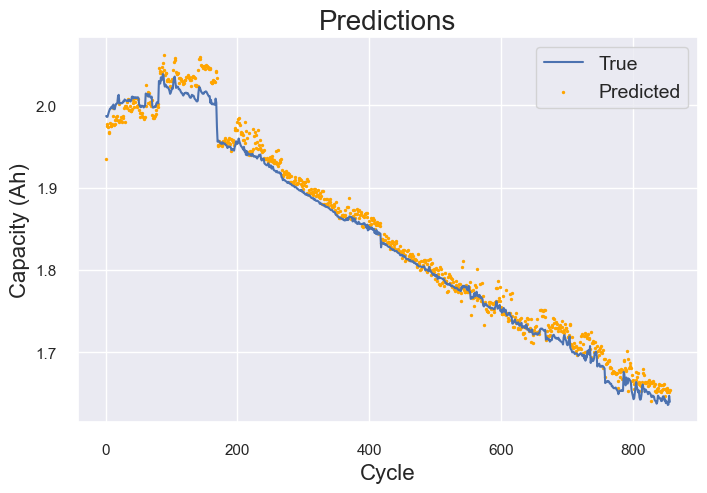

battery 2
第250组数据不完整，跳过；它的stages是：
[(0, 139)]
第251组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
第260组数据不完整，跳过；它的stages是：
[(0, 111)]
第261组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
--------------------------------------------------
原始数量    -> 868
训练数量    -> 横流充电电压：864，恒压充电电流：864
数据长度    -> 横流充电电压：20，恒压充电电流：10
采样间隔    -> 30s
CC阶段电流  -> 2.0A
CC阶段电压  -> 4.0-4.2V
CV阶段电压  -> 4.2V
CV阶段电流  -> 2.0-0.5A
--------------------------------------------------
shape: y_true (864,), y_pred (864,)
RMSE: 0.02079 Ah
Mean error: 0.01618 Ah
Mean relative error: 0.00848
error shape: (864,), relative_error shape: (864,)


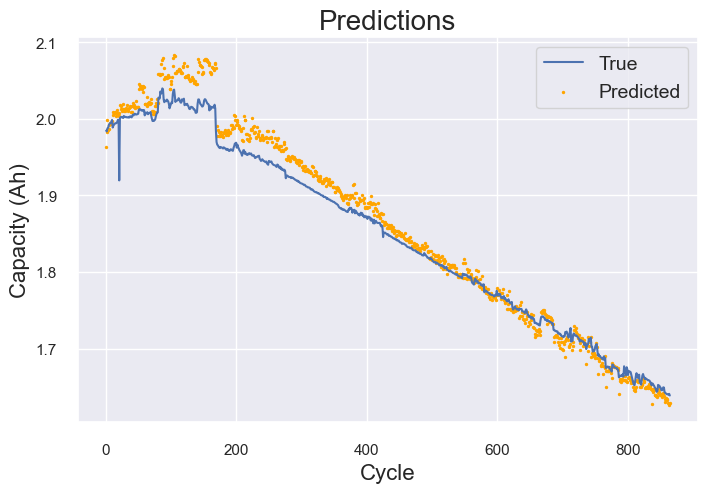

battery 3
--------------------------------------------------
原始数量    -> 899
训练数量    -> 横流充电电压：899，恒压充电电流：899
数据长度    -> 横流充电电压：20，恒压充电电流：10
采样间隔    -> 30s
CC阶段电流  -> 2.0A
CC阶段电压  -> 4.0-4.2V
CV阶段电压  -> 4.2V
CV阶段电流  -> 2.0-0.5A
--------------------------------------------------
shape: y_true (899,), y_pred (899,)
RMSE: 0.01587 Ah
Mean error: 0.01232 Ah
Mean relative error: 0.00669
error shape: (899,), relative_error shape: (899,)


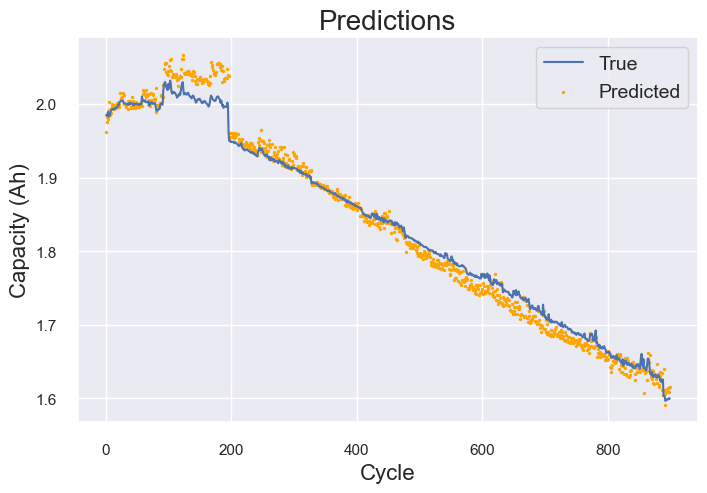

In [13]:
print("battery 1")
evaluate(curves1, labels1)
print("battery 2")
evaluate(curves2, labels2)
print("battery 3")
evaluate(curves3, labels3)


保存 capacity 的标签值和预测值

In [24]:
import json
def save_predictions(predictor, curves, labels, battery_code):
    data_X_v, data_X_i, data_y = utils.get_training_data(curves, labels, NUM_V, NUM_I)

    X = torch.concatenate([torch.tensor(data_X_v), torch.tensor(data_X_i)], dim=1).to(device)
    y = torch.tensor(data_y).to(device)

    info = {
        "original data points number": len(curves),
        "training data points number": f"CC Voltage: {len(data_X_v)}, CV Current: {len(data_X_i)}",
        "length of single data point": f"CC Voltage: {len(data_X_v[0])}, CV Current: {len(data_X_i[0])}",
        "delta t": f"{delta_t}s",
        "CC Current": f"{Ih}A",
        "CC Voltage": f"{Vl}-{Vh}V",
        "CV Voltage": f"{4.2}V",
        "CV Current": f"{Ih}-{Il}A",
    }
    print(info)
    path = f"./2.0A/{battery_code}"
    with open(f'{path}/info.json', 'w') as f:
        json.dump(info, f)
    print(f"Save info to {path}/info.json")

    predictor.eval()
    with torch.no_grad():
        y_true = y.cpu().numpy().flatten()
        y_pred = predictor(X.float()).cpu().numpy().flatten()
        
    print(f"shape: y_true {y_true.shape}, y_pred {y_pred.shape}")
        
    np.save(f"{path}/true_capacity.npy", y_true)
    np.save(f"{path}/pred_capacity.npy", y_pred)
    print(f"Save predictions to {path}/predicted_capacity.npy")
    print('-'*50)
    print()


In [25]:
save_predictions(predictor, curves1, labels1, "1")
save_predictions(predictor, curves2, labels2, "2")
save_predictions(predictor, curves3, labels3, "3")


第250组数据不完整，跳过；它的stages是：
[(0, 109)]
第251组数据不完整，跳过；它的stages是：
[(0, 25), (25, 46), (46, 163), (163, 184)]
--------------------------------------------------
{'original data points number': 858, 'training data points number': 'CC Voltage: 856, CV Current: 856', 'length of single data point': 'CC Voltage: 20, CV Current: 10', 'delta t': '30s', 'CC Current': '2.0A', 'CC Voltage': '4.0-4.2V', 'CV Voltage': '4.2V', 'CV Current': '2.0-0.5A'}
Save info to ./2.0A/1/info.json
shape: y_true (856,), y_pred (856,)
Save predictions to ./2.0A/1/predicted_capacity.npy
--------------------------------------------------

第250组数据不完整，跳过；它的stages是：
[(0, 139)]
第251组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
第260组数据不完整，跳过；它的stages是：
[(0, 111)]
第261组数据不完整，跳过；它的stages是：
[(0, 24), (24, 45), (45, 163), (163, 184)]
--------------------------------------------------
{'original data points number': 868, 'training data points number': 'CC Voltage: 864, CV Current: 864', 'length of single data poin